In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('Dataset\medical.csv')

In [4]:
pd.concat([df.head(), df.tail()])

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500
1337,61,female,29.070,0,yes,northwest,29141.36030


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
numerical_columns = df.iloc[:,:-1].select_dtypes(include=np.number).columns
categorical_columns = df.select_dtypes(include=object).columns

In [8]:
numerical_columns, categorical_columns

(Index(['age', 'bmi', 'children'], dtype='object'),
 Index(['sex', 'smoker', 'region'], dtype='object'))

### EDA

In [9]:
px.histogram(df, x='sex', color='smoker')

In [10]:
px.histogram(df, x='region', color='smoker')

In [11]:
def check_boxplot(df, col):
    fig = px.box(df, x=col)
    fig.update_layout(height=400, width=800)
    fig.show()

In [12]:
check_boxplot(df, 'age')

In [13]:
check_boxplot(df, 'bmi')

In [14]:
def outlier_detection(df, col):
    Q1 = df[col].quantile(.25)
    Q3 = df[col].quantile(.75)

    IQR = Q3 - Q1

    upper_limit = Q3 + 1.5*IQR
    lower_limit = Q1 - 1.5*IQR
    return lower_limit, upper_limit

p = outlier_detection(df, 'bmi')

df = df.query("bmi>= @p[0] & bmi<=@p[1]")

In [15]:
def check_jointplot(df, x, y):
    px.scatter(df, x=x, y=y, marginal_x='histogram').show()
    

In [16]:
check_jointplot(df, x='age', y='charges')

In [17]:
check_jointplot(df, x='bmi', y='charges')

<Axes: >

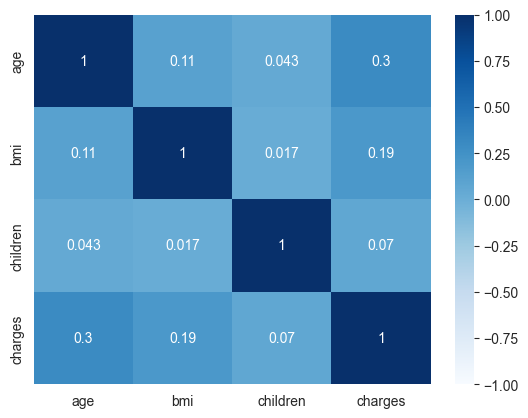

In [35]:
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='Blues', vmin=-1, vmax=1)

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

X =  df.iloc[:,:-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((1063, 6), (266, 6))

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, power_transform
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

numeric = StandardScaler()
categorical = OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric, numerical_columns),
    ('categorical', categorical, categorical_columns)
], remainder='passthrough')

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

lg = LinearRegression()

-cross_val_score(estimator=lg, X=X_train_transformed, y=y_train, cv=5, scoring= 'neg_root_mean_squared_error').mean()

6095.564177341648

In [ ]:
lg.fit(X_train_transformed, y_train)
pred = lg.predict(X_test_transformed)
score = np.sqrt(mean_squared_error(y_test, pred))
score

5873.56203226493

In [ ]:
px.bar(pd.DataFrame({
    'feature' : np.append('intercept', preprocessor.get_feature_names_out(preprocessor.feature_names_in_)),
    'weight' : np.append(lg.intercept_, lg.coef_)
}).sort_values(by='weight', ascending=False), x='weight', y='feature')